In [1]:
import rarfile
import os
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from torch.utils.data import  TensorDataset
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import math
from sklearn.preprocessing import StandardScaler

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [3]:
transform = transforms.Compose([
     transforms.Resize((128, 128)),
    transforms.ToTensor(),
])
batch_size = 100

In [4]:
data_dir = "SignalData"

In [5]:
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'train_spectrograms1'), transform=transform)

# Load the testing dataset
test_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'test_spectrograms1'), transform=transform)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
for X_train, y_train in train_loader:
    pass

In [8]:
y_true=[]
for X_test, y_test in test_loader:
    output=y_test
    y_true.append(output)

In [12]:

# KANLinear definition Soure: https://github.com/Blealtan/efficient-kan/blob/f39e5146af34299ad3a581d2106eb667ba0fa6fa/src/efficient_kan/kan.py#L6
class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.ReLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        return base_output + spline_output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )

In [13]:
class KAN(nn.Module):
    def __init__(self):
        super(KAN, self).__init__()
        # self.conv1 = nn.Conv2d(3, 32, kernel_size=2, padding=1)
        # self.pool1 = nn.MaxPool2d(2)
        # self.conv2 = nn.Conv2d(32, 64, kernel_size=2, padding=1)
        # self.pool2 = nn.MaxPool2d(2)
        # self.kan1 = KANLinear(64*32*32, 256)
        # self.kan2 = KANLinear(256, 6)

        # self.conv1 = nn.Conv2d(3, 32, kernel_size=2, padding=1)
        # self.cbn1=nn.BatchNorm2d(32)
        # self.pool1 = nn.MaxPool2d(2)
        # self.conv2 = nn.Conv2d(32, 64, kernel_size=2, padding=1)
        # self.cbn2=nn.BatchNorm2d(64)
        # self.pool2 = nn.MaxPool2d(2)
        # self.conv3 = nn.Conv2d(64, 128, kernel_size=2, padding=1)
        # self.cbn3=nn.BatchNorm2d(128)
        # self.pool3 = nn.MaxPool2d(2)
        # self.kan1 = KANLinear(128*16*16, 256)
        # self.kan2 = KANLinear(256, 64)
        # self.kan3=KANLinear(64,6)

        self.kan1 = KANLinear(128*128*3, 256)
        self.kan2 = KANLinear(256, 64)
        self.kan3=KANLinear(64,6)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.kan1(x)
        x = self.kan2(x)
        x=self.kan3(x)
        return x

In [14]:
model=KAN()

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/1, Loss: 3.6847


In [17]:
model.eval()
correct = 0
total = 0
predicted_label=[]
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        print(predicted)
        print(y_batch)
        print("")
        predicted_label.append(predicted)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

tensor([5, 2, 2, 2, 4, 5, 4, 4, 2, 4, 4, 5, 2, 5, 2, 4, 2, 4, 2, 4, 2, 5, 5, 2,
        5, 4, 5, 5, 5, 2, 5, 5])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

tensor([4, 5, 4, 2, 5, 5, 5, 5, 5, 5, 4, 4, 5, 5, 5, 5, 2, 5, 2, 5, 4, 5, 2, 2,
        2, 2, 4, 5, 2, 5, 5, 2])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1])

tensor([4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 4, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 4, 2, 2, 2, 2, 4])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 4, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 2, 2, 2])

tensor([2, 4, 4, 4, 2, 2, 5, 2, 2, 2, 2, 2, 2, 4, 2, 4, 2, 4, 2, 2, 2, 4, 4, 2,
        4, 2

In [18]:
from sklearn.metrics import classification_report,ConfusionMatrixDisplay,confusion_matrix

In [19]:
predicted_label=torch.cat(predicted_label)

In [20]:
y_true=torch.cat(y_true)

In [21]:
cm=confusion_matrix(y_true,predicted_label)

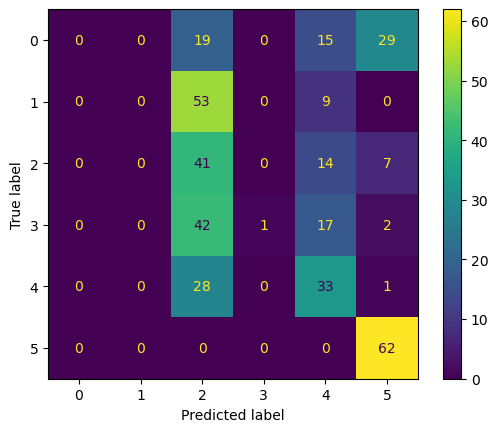

In [22]:
ConfusionMatrixDisplay(cm).plot()